# Classifier free guidance 


1. Class conditioned diffusion models, classifier-free guidance
    * using the score function interpretation to do classifier free guidance
    * few-shot learning example 
    
### Here is what we do in this script
1. Train the model to estimate condition and un-conditional score 

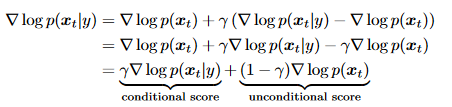

* We train a model that accepts 5d -- where 3rd dimension is the moon and 4th dimension is circles, and outputs 2d data (5th dim is timestep)
* when 3rd dimension is on (1) the model should output the moon distribution, and output circle distribution if the 4th dimension is on
* we use 0-0 for 3rd and 4th dimension to esimate unconditional distribution, 1-1 is invalid combination


In [1]:
generate_new_data = True
train_new_model = True

In [2]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
import os
import os.path as osp

data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
model_paths = osp.join(os.getcwd(), 'saved','saved_models')

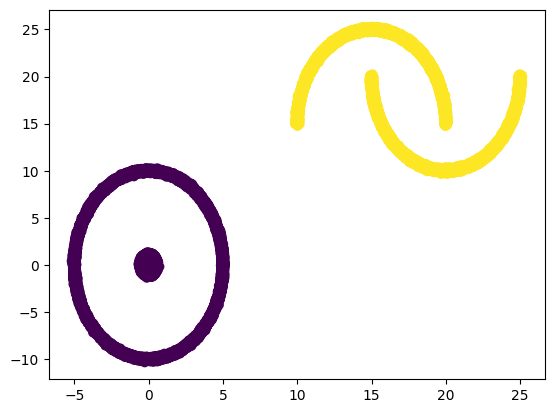

In [4]:
from sklearn import datasets
from matplotlib import pyplot as plt

if generate_new_data:
    circles, _ = datasets.make_circles(1024*128, noise=0.01, factor=0.1, shuffle=True)
    circles = circles* [5., 10.] 
    circles = circles.T
else:
    circles = load_cached(os.path.join(data_paths, '2.circle.pkl'))

if generate_new_data:
    make_moons, labels = datasets.make_moons(n_samples=1024*128, noise=0.01)
    make_moons = make_moons* [5., 10.] 
    make_moons = make_moons.T
else:
    make_moons = load_cached(os.path.join(data_paths, '2.moons.pkl'))

# make moons class 0 and circles class 1
import numpy

moons_3rd_dim = numpy.zeros(len(make_moons[0]))
# half of the values are used to train unconditional model
moons_4th_dim = numpy.hstack([numpy.ones(int(len(make_moons[0])/2)), numpy.zeros(int(len(make_moons[0])/2))])

circles_4th_dim = numpy.zeros(len(circles[0]))
# half of the values are used to train unconditional model
circles_3rd_dim = numpy.hstack([numpy.ones(int(len(circles[0])/2)), numpy.zeros(int(len(circles[0])/2))])

make_moons = numpy.vstack([make_moons+15, moons_3rd_dim, moons_4th_dim])
circles = numpy.vstack([circles, circles_3rd_dim, circles_4th_dim])

if generate_new_data:
    complex_data = numpy.hstack([make_moons, circles ]) 
    numpy.random.shuffle(complex_data.T)
    write_cached(complex_data, os.path.join(data_paths, '2.complex_classified.pkl'))
else:
    complex_data = load_cached(os.path.join(data_paths, '2.complex_classified.pkl'))

# plotting class-labeled da1a, 
data__ = numpy.vstack([complex_data[0], complex_data[1], complex_data[2] + complex_data[3]*2])
data__ = data__.T[data__[2]>0, :]
data__ = data__.T
plt.scatter(data__[0], data__[1], c=data__[2])

C:\Users\varun\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-1.0, 1.0)

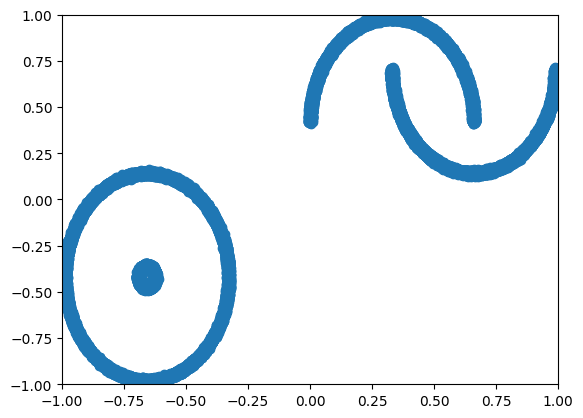

In [5]:
import torch

complex_data = torch.Tensor(complex_data)
# transform to range
def transform(data):
    min_, max_ = torch.min(data, axis=1), torch.max(data, axis=1)
    data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    return data_transformed, min_, max_

data_transformed, min_, max_ = transform(complex_data[:2, :])
data_transformed = torch.vstack([data_transformed, complex_data[2], complex_data[3]])
plt.scatter(data_transformed[0], data_transformed[1])
plt.xlim([-1, 1])
plt.ylim([-1, 1])

(-15.0, 30.0)

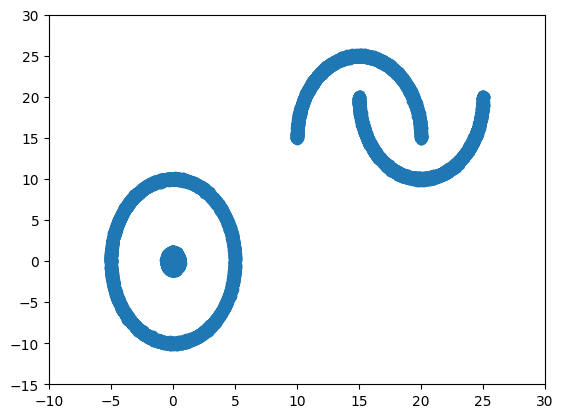

In [6]:
def reverse_transform(data_transformed, min_, max_):
    # data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    data = (data_transformed + 1).mul((max_.values - min_.values)[:, None]).add(min_.values[:, None]*2)/2
    return data
    
complex_data = reverse_transform(data_transformed[:2, :], min_, max_)
complex_data = numpy.vstack([complex_data, data_transformed[2], data_transformed[3]])

plt.scatter(complex_data[0], complex_data[1])
plt.xlim([-10, 30])
plt.ylim([-15, 30])

In [7]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.02)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

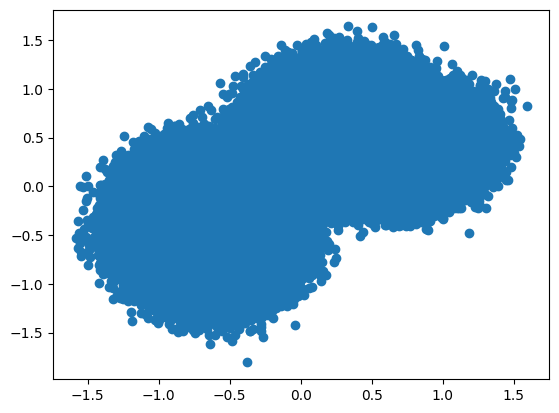

In [8]:
# Train model
timesteps = 200
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = torch.sqrt(variance)

import torch.nn.functional as F

alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = torch.log(1-alphas) + torch.log(1-alphas_) - torch.log(1-alphas_prev_)
sigma_squared_q_t_corrected = torch.exp(log_sigma_squared_q_t)

# how to add noise to the data
def get_noisy(batch, timestep):
    # we will use the reparameterization trick
    noise_at_t = torch.normal(0, std=1, size=batch.size())
    added_noise_at_t = batch.mul(alphas_[timestep]) + noise_at_t.mul(sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(alphas_[timestep])
    return true_data
    
added_noise_at_t, noise = get_noisy(data_transformed[:2, :], 20)
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = torch.log(torch.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = torch.exp(log_posterior_variance)

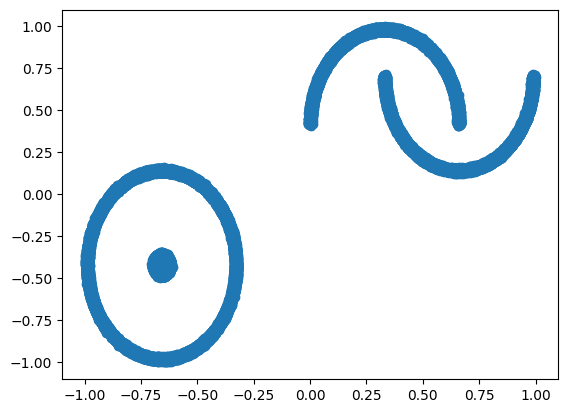

In [9]:
true_data = recover_original(added_noise_at_t, 20, noise)
plt.scatter(true_data[0], true_data[1])

# building a model

In [10]:
learning_rate = 1e-3
batch_size = 2048
epochs = 1

from torch import nn

    
class DenoisingModelSequential(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModelSequential, self).__init__()
        # hidden_units = 32
        
        self.mlp = nn.Sequential(
            nn.Linear(5, int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), int(hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/2), int(hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/4), int(hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/8), int(hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/16), int(hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/8), int(hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/4), int(hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units/2), int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), 2, bias=True)
        )
        
        
    def forward(self, x):
        x = self.mlp(x)
        return x
      
denoising_model = DenoisingModelSequential(128)
print(denoising_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

DenoisingModelSequential(
  (mlp): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): GELU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): GELU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): GELU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): GELU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): GELU()
    (10): Linear(in_features=8, out_features=16, bias=True)
    (11): GELU()
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): GELU()
    (14): Linear(in_features=32, out_features=64, bias=True)
    (15): GELU()
    (16): Linear(in_features=64, out_features=128, bias=True)
    (17): GELU()
    (18): Linear(in_features=128, out_features=2, bias=True)
  )
)


loss: 0.329738  [   10/ 2048]


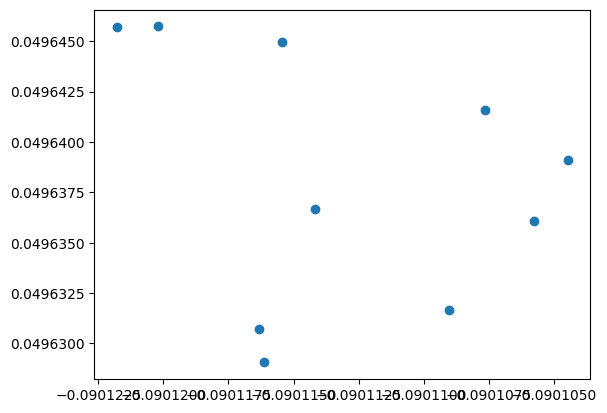

In [11]:
##### testing neural network above

test_noise_step = 5
data_noisy, noise = get_noisy(data_transformed[:2, 0:10], test_noise_step)

t_ = torch.Tensor([test_noise_step])
t_ = t_.repeat(10)
data_noisy = torch.vstack([data_noisy, data_transformed[2:4, 0:10], t_])

with torch.no_grad():
    for epoch in range(1, epochs+1):
        data_pred = denoising_model(data_noisy.T)
        loss_ = loss_func(noise[:, 0:10].T, data_pred)
        loss, current = loss_.item(), 1 * 10
        print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    
# print(data_pred, data_transformed[:, 1:10].T)

plt.scatter(data_pred.T[0], data_pred.T[1])

In [12]:
# v = torch.sqrt(1/2 * (1/sigma_squared_q_t) * ((betas)**2 / ((1) * alphas)))

# plt.plot(v)

In [13]:
from copy import deepcopy
import pickle
import sys

epochs = 300

def train_model(denoising_model, data_transformed, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization
        
    if train_new_model or not os.path.exists(osp.join(model_paths, model_name + '.pt')):
        losses = []
        for epoch in range(1, epochs+1):
            for n in range(1, int(len(data_transformed[0])/batch_size) + 1):
                data_in_batch = data_transformed[:, (n-1)*batch_size:(n*batch_size)]
                idx = torch.randint(0, timesteps-1, (batch_size, )).long()
                timestep = idx.add(1)
                data_noisy, noise = get_noisy(data_in_batch[:2, :], timestep)
                optimizer.zero_grad(set_to_none=True)
                data_noisy_stacked = torch.vstack([data_noisy, data_in_batch[2:4, :], timestep])
                pred_data = denoising_model(data_noisy_stacked.T)
                if not energy_method:
                    imp_weight = torch.sqrt(1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep])))
                    # loss on prediction
                    loss_ = loss_func(noise.mul(imp_weight), pred_data.T.mul(imp_weight))
                else:
                    ## Energy function interpretation
                    imp_weight = torch.sqrt(1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep])))
                    # loss on prediction
                    loss_ = loss_func(noise.div(-sd[timestep]).mul(imp_weight), pred_data.T.mul(imp_weight))


                loss_.backward()
                optimizer.step()
                
            ## evaluating noise on a fixed timestep to calculate best model
            with torch.no_grad():
                one_timestep = torch.Tensor([1]).repeat(batch_size).long()
                data_noisy_temp, noise_temp = get_noisy(data_in_batch[:2, :], one_timestep)
                data_noisy_stacked_temp = torch.vstack([data_noisy_temp, data_in_batch[2:4, :], one_timestep])
                pred_data_temp = denoising_model(data_noisy_stacked_temp.T)
                # loss on prediction
                if not energy_method:
                    loss_temp = loss_func(noise_temp.mul(1), pred_data_temp.T.mul(1))
                else:
                    loss_temp = loss_func(noise_temp.div(-sd[1]).mul(1), pred_data_temp.T.mul(1))
                losses.append(loss_temp.item())

            if loss_temp.item() < best_loss:
                best_loss = loss_temp.item()
                print(f"saving epoch: {epoch} loss: {best_loss:>7f}")
                torch.save(deepcopy(denoising_model.state_dict()), osp.join(model_paths, model_name + '.pt'))
                write_cached([data_noisy, pred_data, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))

            if epoch % 20 == 0:
                loss = loss_temp.item()
                print(f"epoch: {epoch} loss: {loss:>7f}")

    if os.path.exists(osp.join(model_paths, model_name + '.pt')):
        denoising_model.load_state_dict(torch.load(osp.join(model_paths, model_name + '.pt')))
        data_noisy, pred_data, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
        return data_noisy, pred_data, data_in_batch, timestep, losses

saving epoch: 1 loss: 32.040504
saving epoch: 2 loss: 31.131868
saving epoch: 3 loss: 30.965536
saving epoch: 5 loss: 30.922684
saving epoch: 7 loss: 30.906561
saving epoch: 9 loss: 30.872896
saving epoch: 14 loss: 30.665668
saving epoch: 18 loss: 30.651873
saving epoch: 20 loss: 30.581306
epoch: 20 loss: 30.581306
saving epoch: 22 loss: 30.243946
saving epoch: 25 loss: 30.188017
saving epoch: 28 loss: 29.514402
saving epoch: 30 loss: 28.762611
saving epoch: 34 loss: 28.422443
saving epoch: 36 loss: 28.217793
saving epoch: 37 loss: 27.088291
saving epoch: 39 loss: 26.114475
epoch: 40 loss: 27.234514
saving epoch: 43 loss: 26.074055
saving epoch: 45 loss: 25.966179
saving epoch: 47 loss: 25.477577
saving epoch: 49 loss: 24.805805
saving epoch: 53 loss: 24.791443
saving epoch: 55 loss: 24.440521
saving epoch: 59 loss: 24.113174
epoch: 60 loss: 24.675686
saving epoch: 61 loss: 24.004333
saving epoch: 65 loss: 23.691097
saving epoch: 66 loss: 23.667095
saving epoch: 67 loss: 23.303288
savi

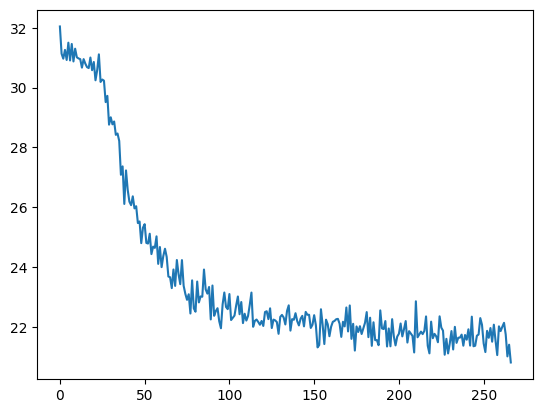

In [14]:
data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'complex_classifier_free_guidance.energy_method', train_new_model= (train_new_model | generate_new_data), energy_method=True)
plt.plot(torch.Tensor(losses))

In [15]:
mean_coeff_1 = torch.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = torch.sqrt(alphas_prev_) * betas / variance

def generate_data(denoising_model, tt=timesteps, energy_method=False, clipped_version=False, labels=None):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 1024*1
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    data_noisy =  torch.normal(mean=0, std=1, size=(2, batch_size_generation))
    # data_noisy_x =  torch.normal(mean=mean_last_step[0], std=std_last_step[0], size=(1, batch_size_generation))

    # data_noisy = torch.vstack([data_noisy_x, data_noisy_y])
    if not labels:
      labelled_values = torch.zeros((2, batch_size_generation))
    elif labels=="circles":
      labelled_values = torch.vstack([torch.ones(batch_size_generation), torch.zeros(batch_size_generation)])
    elif labels=="moon":
      labelled_values = torch.vstack([torch.zeros(batch_size_generation), torch.ones(batch_size_generation)])
    elif labels=="mixed":
      batch_size_generation_ = int(batch_size_generation/2)
      labelled_values_1 = torch.vstack([torch.ones(batch_size_generation_), torch.zeros(batch_size_generation_)])
      labelled_values_2 = torch.vstack([torch.zeros(batch_size_generation_), torch.ones(batch_size_generation_)])
      labelled_values = torch.hstack([labelled_values_1, labelled_values_2])
      
    datas = []
    datas.append(torch.vstack([data_noisy.cpu().detach(), labelled_values]))
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, tt):
            timestep = tt-t
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, labelled_values, t_repeated])
            pred_data = denoising_model(data_stacked.T)
            if not clipped_version:
                if not energy_method:
                    #### Note: this implementation has numerical issues, so calculating it another way below to avoid numerical issues
                    # mean_data_1 = data_in_batch.T.mul(1/torch.sqrt(alphas_[timestep]))
                    # mean_data_2 = pred_data.mul((1-alphas[timestep])/(sd[timestep]*torch.sqrt(alphas[timestep])))
                    # mean_data = mean_data_1.sub(mean_data_2)
                    ######

                    # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                    multiplier = torch.exp(torch.log((betas[timestep])) - torch.log(sd[timestep]))
                    mean_data = (data_in_batch.T.sub(pred_data.mul(multiplier))).div(torch.sqrt(alphas[timestep]))
                else:
                    ##
                    # Energy function interpretation
                    mean_data = (data_in_batch.T.add(pred_data.mul((betas[timestep])))).div(torch.sqrt(alphas[timestep]))
                    ##
            else:
                # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
                # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
                if not energy_method:
                    x_reconstructed = data_in_batch.T.sub(pred_data.mul(sd[timestep])).div(torch.sqrt(alphas_[timestep]))
                    if timestep >= 5:
                        x_reconstructed = torch.clip(x_reconstructed, -1., 1.)
                else:
                    # energy method and clipping to improve stabalization
                    x_reconstructed = data_in_batch.T.add(pred_data.mul(variance[timestep])).div(torch.sqrt(alphas_[timestep]))
                    if timestep >= 5:
                        x_reconstructed = torch.clip(x_reconstructed, -1., 1.)
                
                mean_data_1 = data_in_batch.T.mul(mean_coeff_1[timestep])
                mean_data_2 = x_reconstructed.mul(mean_coeff_2[timestep])
                mean_data = mean_data_1.add(mean_data_2)
                    
                

            posterior_data = posterior_variance_corrected[timestep]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).T
            datas.append(torch.vstack([data_in_batch.cpu().detach(), labelled_values]))
    return datas, data_in_batch

(-15.0, 30.0)

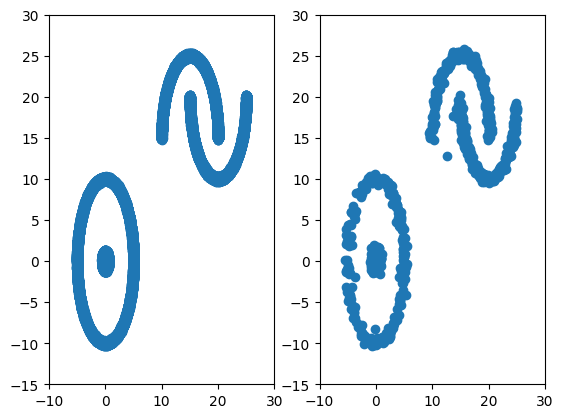

In [16]:
tt = 200
datas, data_in_batch = generate_data(denoising_model, tt, energy_method=True, clipped_version=True, labels=None)

data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(complex_data[0], complex_data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-10, 30])
ax1.set_ylim([-15, 30])

ax2.set_xlim([-10, 30])
ax2.set_ylim([-15, 30])

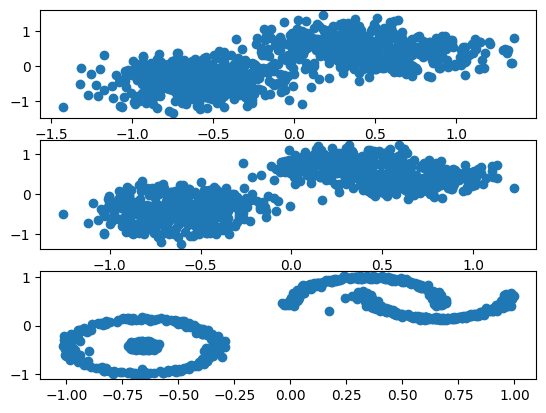

In [17]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

In [18]:
!pip install imageio

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


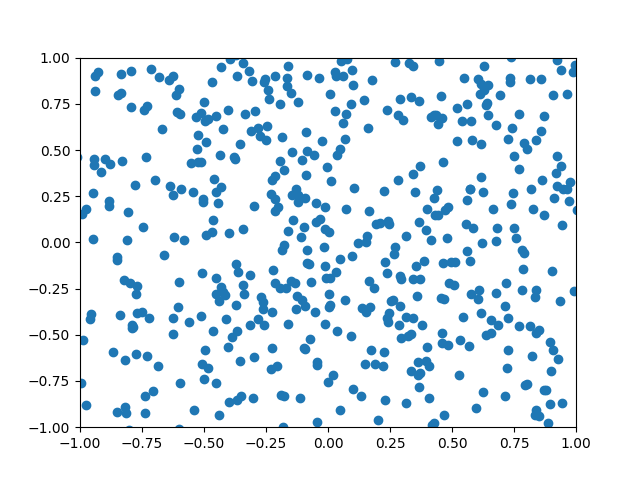

In [19]:
import imageio 
from IPython.display import Image

def print_gif(datas, name, color=False):
  filenames = []
  for i in range(0, tt-20, 10):
    # plot the line chart
    if color:
      plt.scatter(datas[i][0], datas[i][1], c=datas[i][2]+ 2*datas[i][3])
    else:  
      plt.scatter(datas[i][0], datas[i][1])
    plt.ylim(-1,1)
    plt.xlim(-1, 1)

    # create file name and append it to a list
    filename = f'para-{i}.png'
    filenames.append(filename)

    # save frame
    plt.savefig(filename)
    plt.close()
    
  for j in range(tt-20, tt-1, 1):
    # plot the line chart
    if color: 
      plt.scatter(datas[j][0], datas[j][1], c=datas[j][2]+ 2*datas[j][3])
    else:
      plt.scatter(datas[j][0], datas[j][1])
    plt.ylim(-1,1)
    plt.xlim(-1, 1)

    # create file name and append it to a list
    filename = f'para-{i+j}.png'
    filenames.append(filename)

    # save frame
    plt.savefig(filename)
    plt.close()

  images = list(map(lambda filename: imageio.imread(filename), filenames))
      
  imageio.mimsave(os.path.join(name), images, fps=3) # modify the frame duration as needed

  # Remove files
  for filename in set(filenames):
      os.remove(filename)
  with open(name,'rb') as f:
    display(Image(data=f.read(), format='png'))
  
print_gif(datas, 'class_conditioned_no_labels.gif')

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


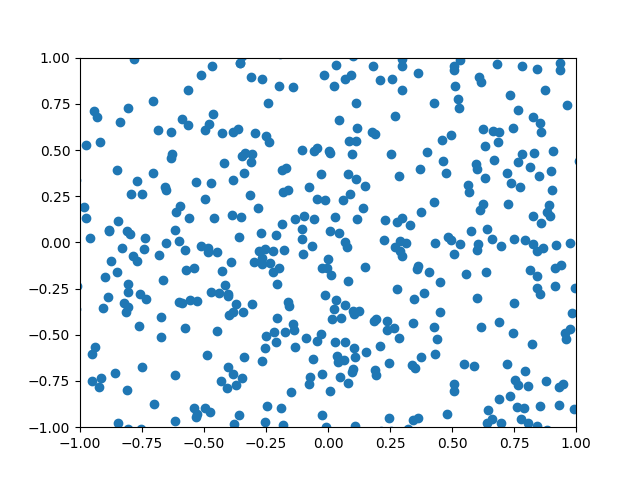

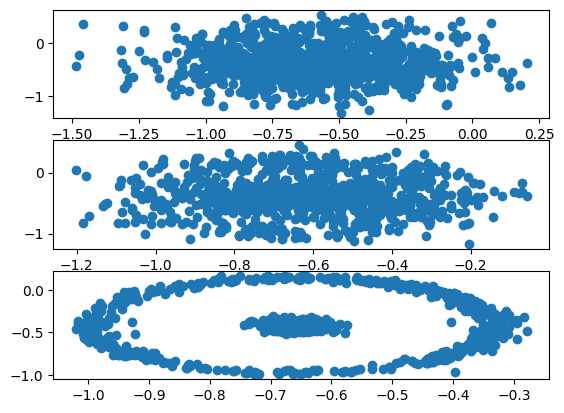

In [20]:
datas, data_in_batch = generate_data(denoising_model, tt, energy_method=True, clipped_version=True, labels="circles")
print_gif(datas, 'class_conditioned_circles.gif')

_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


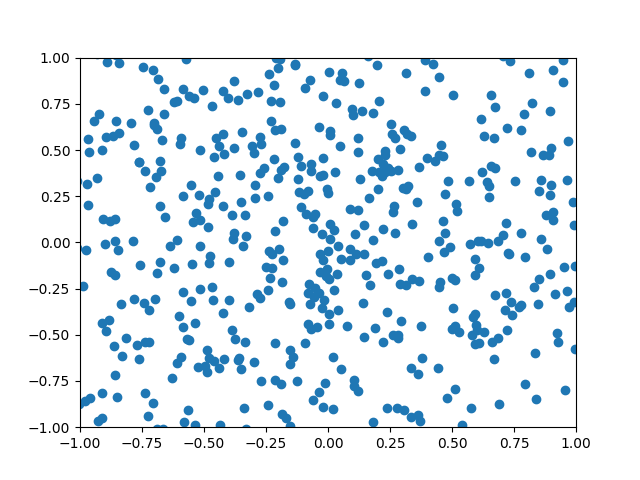

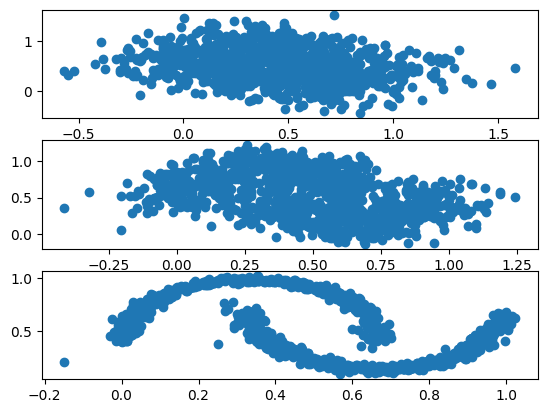

In [21]:
datas, data_in_batch = generate_data(denoising_model, tt, energy_method=True, clipped_version=True, labels="moon")
print_gif(datas, 'class_conditioned_moon.gif')

_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


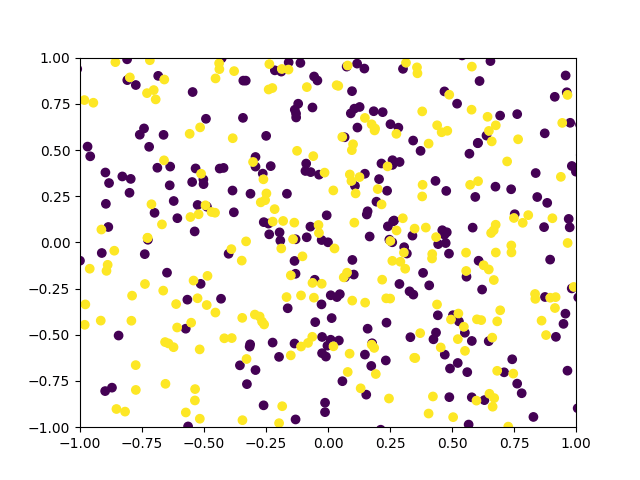

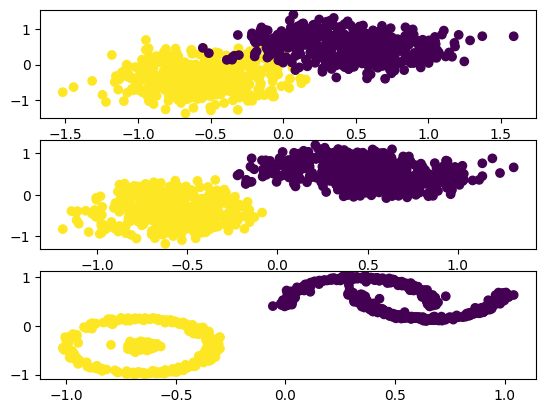

In [22]:
datas, data_in_batch = generate_data(denoising_model, tt, energy_method=True, clipped_version=True, labels="mixed")
print_gif(datas, 'class_conditioned_moon_circles.gif', color=True)

_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1], c=datas[tt - 25][2])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1], c=datas[tt - 12][2])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1], c=datas[tt - 1][2])

# experiments with few shot learning approach
* We will train unsupervised model 
* then finetune using small batch of samples

DenoisingModelSequential(
  (mlp): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): GELU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): GELU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): GELU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): GELU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): GELU()
    (10): Linear(in_features=8, out_features=16, bias=True)
    (11): GELU()
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): GELU()
    (14): Linear(in_features=32, out_features=64, bias=True)
    (15): GELU()
    (16): Linear(in_features=64, out_features=128, bias=True)
    (17): GELU()
    (18): Linear(in_features=128, out_features=2, bias=True)
  )
)
saving epoch: 1 loss: 31.172255
saving epoch: 5 loss: 30.698658
saving epoch: 15 loss: 30.653824
saving epoch: 17 loss: 30.252243
epoch: 20 loss: 31.389006
saving epoch: 30 loss: 30.170515
savin

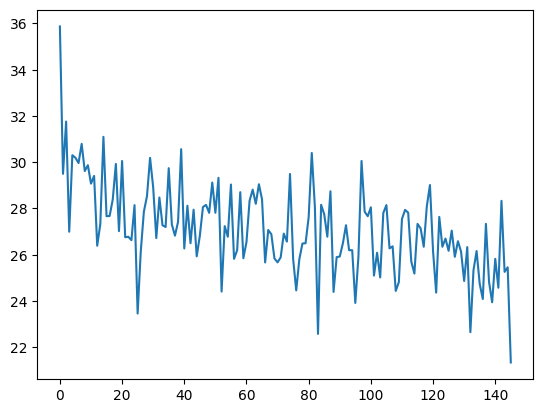

In [23]:
make_complex_model = DenoisingModelSequential(128)
print(make_complex_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_complex_model.parameters(), lr=learning_rate)

complex_data_normalized = numpy.array(data_transformed).T
complex_data_normalized_unlabelled = complex_data_normalized[(complex_data_normalized[:, 2] + complex_data_normalized[:, 3]) == 0]
complex_data_normalized_labelled = complex_data_normalized[(complex_data_normalized[:, 2] + complex_data_normalized[:, 3]) != 0][0:2048, :]

batch_size = 2048
# complex_data_normalized = torch.Tensor(numpy.vstack([complex_data_normalized_unlabelled, complex_data_normalized_labelled]).T)
_, _, _, _, _ = train_model(make_complex_model, torch.Tensor(complex_data_normalized_unlabelled.T), 'complex_classifier_free_guidance.energy_method.few_shot_unlabelled', train_new_model=(train_new_model | generate_new_data), energy_method=True)

batch_size = 128
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_complex_model, torch.Tensor(complex_data_normalized_labelled.T), 'complex_classifier_free_guidance.energy_method.few_shot_labelled', train_new_model=(train_new_model | generate_new_data), energy_method=True)
plt.plot(torch.Tensor(losses))

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


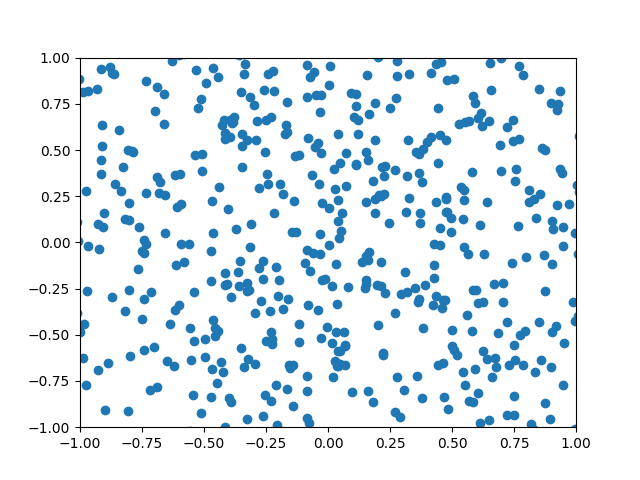

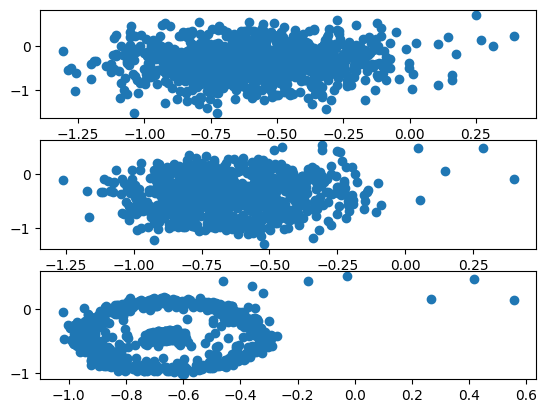

In [24]:
datas, data_in_batch = generate_data(make_complex_model, tt, energy_method=True, clipped_version=True, labels="circles")
print_gif(datas, 'class_conditioned_circles_few_shot.gif')

_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


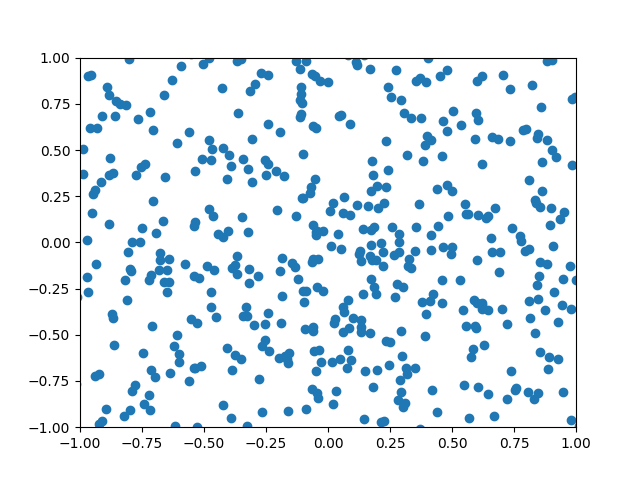

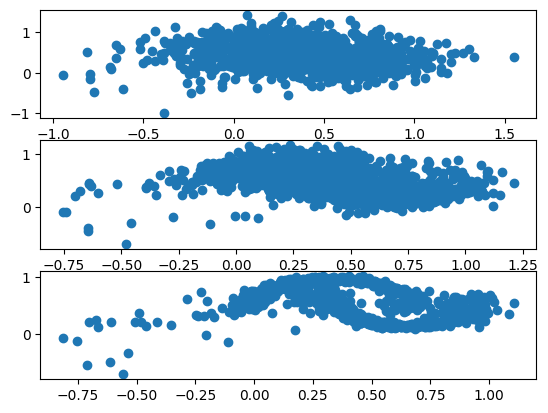

In [25]:
datas, data_in_batch = generate_data(make_complex_model, tt, energy_method=True, clipped_version=True, labels="moon")
print_gif(datas, 'class_conditioned_moon_few_shot.gif')

_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

C:\Users\varun\AppData\Local\Temp\ipykernel_11800\2929195350.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


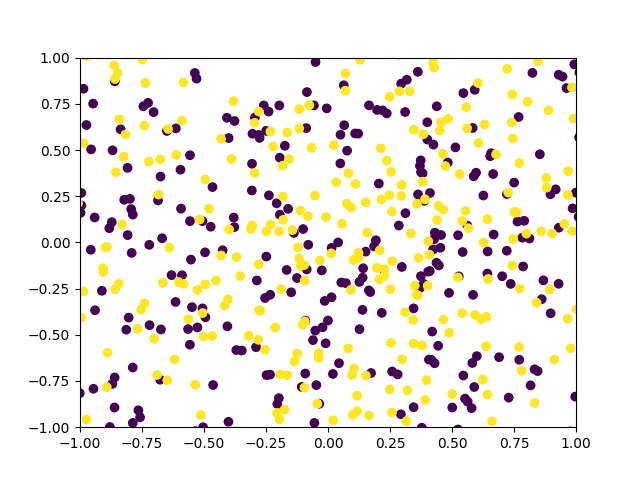

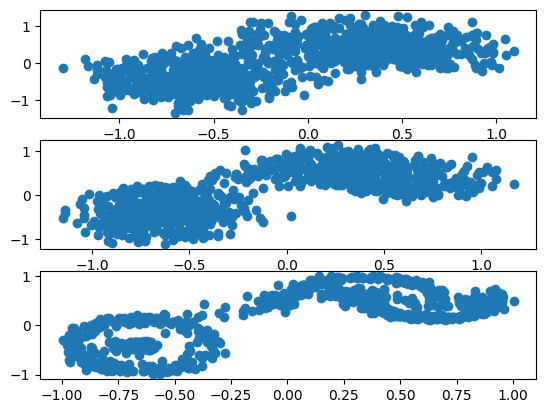

In [26]:
datas, data_in_batch = generate_data(make_complex_model, tt, energy_method=True, clipped_version=True, labels="mixed")
print_gif(datas, 'class_conditioned_mixed_few_shot.gif', color=True)

_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])